In [1]:
import torch
import algos
import lin_reg_algos
import matplotlib.pyplot as plt
import numpy as np

In [77]:
def coinpress_linreg(x, y, beta, c, r, total_budget):
    """
    input:
    output:
    beta_hat = mean_est @ np.inv(cov_est)
    """
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    # TODO: private beta_norm_sqr !!
    beta_norm_sqr = np.linalg.norm(beta) ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget)
    cov_est = coinpress_linalg_covariance(x, d, 2, total_budget)
    beta_hat = mean_est @ np.linalg.inv(cov_est)
    return beta_hat

In [78]:
def no_cov_est_priv_linreg(x, y, beta, c, r, total_budget):
    '''multiplies by (1/n)*np.linalg.inv(X.T@X) instead of inverse of covariance estimation'''
    
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    # TODO: private beta_norm_sqr !!
    beta_norm_sqr = np.linalg.norm(beta) ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget)
    beta_hat = mean_est @ np.linalg.inv((1/n)*x.T@x)
    return beta_hat

In [79]:
def coinpress_linalg_covariance(x, d, t=2, total_budget=0.5):
    '''need X and args={d, u, rho, t}'''
    x = torch.FloatTensor(x)
    
    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t

    n = len(x)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    # u = upper bound on largest eigenvalue on true covariance matrix
    u = 10 * np.sqrt(d)
    args = Args(n, d, u, rho, t)
    return algos.cov_est(x, args)

In [80]:
def coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget=0.5):
    z = z / np.sqrt(2 * beta_norm_sqr + 1)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    return algos.multivariate_mean_iterative(z, c, r, 2, rho) * np.sqrt(2 * beta_norm_sqr + 1)

In [81]:
def losses(n_values, d, iters, total_privacy_budget, beta_mean=0, beta_var=1.0):
    """
    returns excess loss of the private, coinpress linear regression solution
    and excess loss for the closed form solution of linear regression.

    where excess loss = E[(<x,beta_hat> - y)**2 - (<x,beta> - y)**2]
    """

    no_cov_est_priv_excess_losses = []
    nonpriv_excess_losses = []
    priv_excess_losses = []

    for n in n_values:
        no_cov_est_priv_losses_for_n = []
        nonpriv_losses_for_n = []
        priv_losses_for_n = []

        for i in range(iters):
            c = [0] * d
            r = 100 * np.sqrt(d)

            underlying_dist = generate_normal_underlying_dist(d, beta_mean, beta_var)
            x, y, _ = generate_data(n, d, underlying_dist)

            no_cov_est_priv_beta_hat = no_cov_est_priv_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            no_cov_est_priv_losses_for_n.append(excess_loss(no_cov_est_priv_beta_hat, underlying_dist[0], d))
            
            priv_beta_hat = lin_reg_algos.coinpress_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            priv_losses_for_n.append(excess_loss(priv_beta_hat, underlying_dist[0], d))

            nonpriv_beta_hat = linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(excess_loss(nonpriv_beta_hat, underlying_dist[0], d))

        no_cov_est_losses_for_n = np.array(no_cov_est_priv_losses_for_n)
        no_cov_est_priv_excess_losses.append(np.mean(no_cov_est_priv_losses_for_n))
        
        priv_losses_for_n = np.array(priv_losses_for_n)
        priv_excess_losses.append(np.mean(priv_losses_for_n))
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_excess_losses.append(np.mean(nonpriv_losses_for_n))
        
    plt.plot(n_values, priv_excess_losses, 'b', label='excess losses using algorithm')
    plt.plot(n_values, nonpriv_excess_losses, 'r', label='excess losses using closed form sol')
    plt.plot(n_values, no_cov_est_priv_excess_losses, 'y', label='excess losses using algo w/o cov est.')
    plt.legend(loc="upper right")

    return priv_excess_losses, nonpriv_excess_losses

In [82]:
def generate_normal_underlying_dist(d, beta_mean, beta_var):
    """ generates beta, <X,beta> = y"""
    underlying_dist = np.random.normal(beta_mean, beta_var, (1, d))
    return np.array(underlying_dist)

In [83]:
def generate_data(n, d, underlying_dist):
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""

    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = np.random.normal(0, 1.0, (n, d))
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)

    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)

    return X, y, z

In [84]:
def linreg_closed_form_solution(x, y):
    return np.linalg.inv(x.T @ x) @ x.T @ y

In [85]:
def excess_loss(beta_hat, beta, d):
    """
    Generate 1000 d-dimensional x values and y values to test excess loss
    of our predicted beta_hat vs. underlying distribution beta
    """

    n = 1000
    x = np.random.normal(0, 1.0, (n, d))
    x = np.array(x)
    y = []

    for i in range(n):
        y.append(np.dot(beta, x[i]) + np.random.normal(0, 1.0))
    y = np.array(y)

    sum_losses = 0
    for i in range(n):
        predicted_dist = (x[i] @ beta_hat - y[i]) ** 2
        actual_dist = (x[i] @ beta - y[i]) ** 2  # if this = 1, it's essentially the same thing as n -> \inf
        loss = predicted_dist - actual_dist
        sum_losses += loss
    return sum_losses / n

([572.2075603704574,
  501.13181017189004,
  2060.845506874173,
  1200.2778088636578,
  306.56801997129094,
  3219.0499443132094,
  94.53980530339285,
  5.285293884083142,
  12.061090825773276,
  0.5553036444284136,
  0.26476434522676945,
  0.1889626715093884,
  0.13720630802844247,
  0.10025815259783492],
 [0.051664849945508316,
  0.024622194195890193,
  0.017041071866892608,
  0.012670119471532838,
  0.008923179534696315,
  0.009473686910949132,
  0.007048388826439793,
  0.006136624581586687,
  0.0057657303558431815,
  0.0055593920128448725,
  0.00468887808089563,
  0.00405198600138566,
  0.004347037851663076,
  0.003993924997134326])

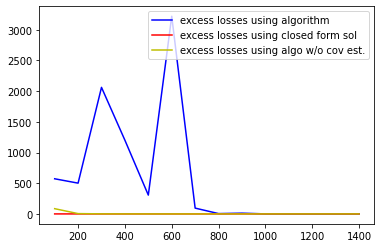

In [89]:
n_values = list(range(100, 1500, 100))#[100,400,900,1000,1050,2000,2500,3000,3500,4000,6000]#,8000,10000]
d = 5
iters = 200
total_privacy_budget=0.5

losses(n_values, d, iters, total_privacy_budget)

- dist between X.T@X and identity (Frobenius norm)
- dist between coinpress_cov and identity (also F norm)

In [12]:
d = 5
n = 2000

X = np.random.normal(0, 1.0, (n, d))
X = np.array(X)

errors = []
cov_errors = []
for i in range(100):
    errors.append(np.linalg.norm(((1/n)*X.T@X - np.eye(d)), 'fro'))
    cov_errors.append(np.linalg.norm((coinpress_linalg_covariance(X, d, t=2, total_budget=0.5) - (1/n)*X.T@X), 'fro'))
    
print(np.mean(np.array(errors)))
print(np.mean(np.array(cov_errors)))

0.1367344015959184
0.1531002930491572


TODO:
- add semi-private losses (cov lin reg with 1/n X.T@X) as another line on graph for sanity check abt what coinpress cov est. does DONE
- when we generate actual data, try sampling x from something other than standard gaussian - extension. 
- experiments with d=2 (can visualize data, easier to experiment, validate assumptions, etc)
- need to split total_privacy_budget between mean & covariance (conduct experiment?) / (start out even split?) / (bottleneck = mean est split, maybe allocate more here)
- real in-practice things to think abt/ note - for what values of n does the algorithm start working well / bottlenecked?
- diff measurements of error?